### Q: Can we get the CNNs to overfit to the data?

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES
from netam.framework import (
    SHMoofDataset,
    RSSHMBurrito,
    trimmed_shm_model_outputs_of_crepe,
)
from epam.torch_common import pick_device

from epam import sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, dataset_dict
from shmex import shm_zoo
from shmex.shm_eval import ragged_np_pcp_encoding, oe_plot_of, show_figure, optimized_branch_lengths_of_crepe

Using Metal Performance Shaders


We're just going to use shmoof training data, the same data used to train the context NT model.

In [2]:
site_count = 500
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
subsampled_train_df = train_df.iloc[::int(len(train_df)/5000)].copy().reset_index(drop=True)

In [3]:
device = pick_device()
train_data_5mer = SHMoofDataset(train_df, kmer_length=5, site_count=site_count)
val_data_5mer = SHMoofDataset(val_df, kmer_length=5, site_count=site_count)

train_data_3mer = SHMoofDataset(train_df, kmer_length=3, site_count=site_count)
val_data_3mer = SHMoofDataset(val_df, kmer_length=3, site_count=site_count)

for data in [train_data_5mer, val_data_5mer, train_data_3mer, val_data_3mer]:
    data.to(device)

Using Metal Performance Shaders


In [ ]:
def oe_plot_of_crepe(crepe, pcp_df, branch_lengths, title):
    crepe.to("cpu")
    ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    site_count = crepe.encoder.site_count
    mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(pcp_df["parent"], pcp_df["child"], site_count)
    fig, oe_results = oe_plot_of(ratess, masks, branch_lengths, mut_indicators, title)
    oe_results.pop("counts_twinx_ax")
    return fig, oe_results


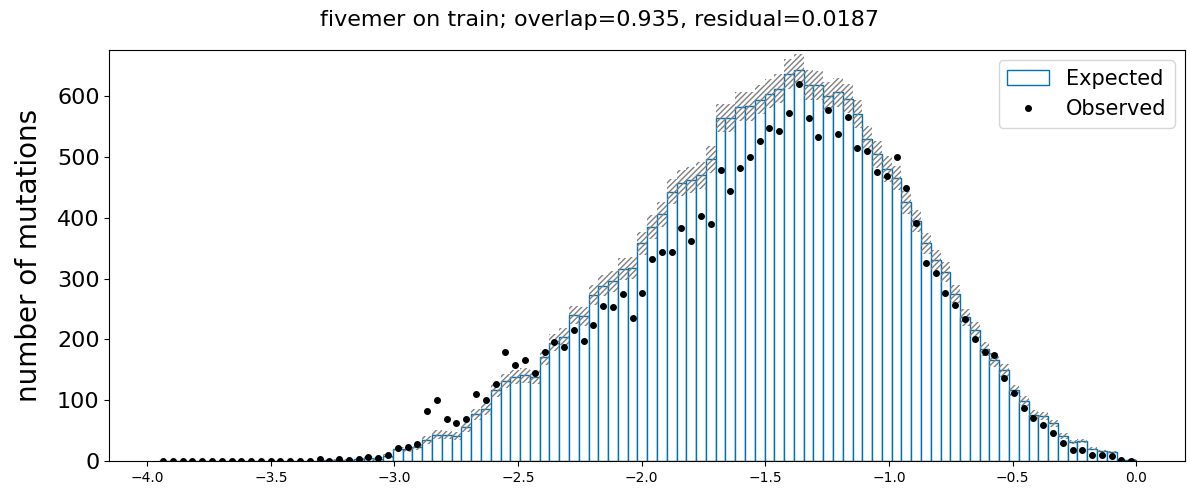

In [ ]:
fivemer_crepe = framework.load_crepe("trained_models/fivemer")
show_figure(oe_plot_of_crepe(fivemer_crepe, subsampled_train_df, subsampled_train_df["branch_length"], "fivemer on train")[0])

In [ ]:
big_cnn_model = shm_zoo.create_model("cnn_ind_lrg")
big_cnn_model.to(device)
cnn_burrito = RSSHMBurrito(train_data_3mer, val_data_3mer, big_cnn_model, name="cnn_ind_lrg")
cnn_burrito.train(epochs=100)
cnn_burrito.reset_optimization()
cnn_burrito.train(epochs=100)
cnn_burrito.reset_optimization()
cnn_burrito.train(epochs=100)
cnn_burrito.save_crepe("trained_models/cnn_ind_lrg")
cnn_crepe = cnn_burrito.to_crepe()

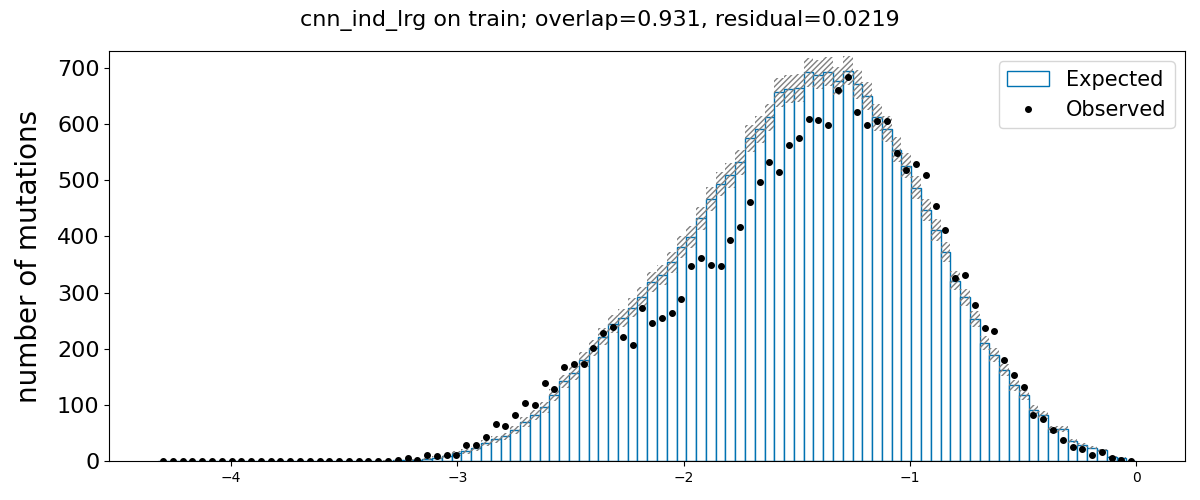

In [5]:
cnn_crepe = framework.load_crepe("trained_models/cnn_ind_lrg")
show_figure(oe_plot_of_crepe(cnn_crepe, subsampled_train_df, subsampled_train_df["branch_length"], "cnn_ind_lrg on train")[0])

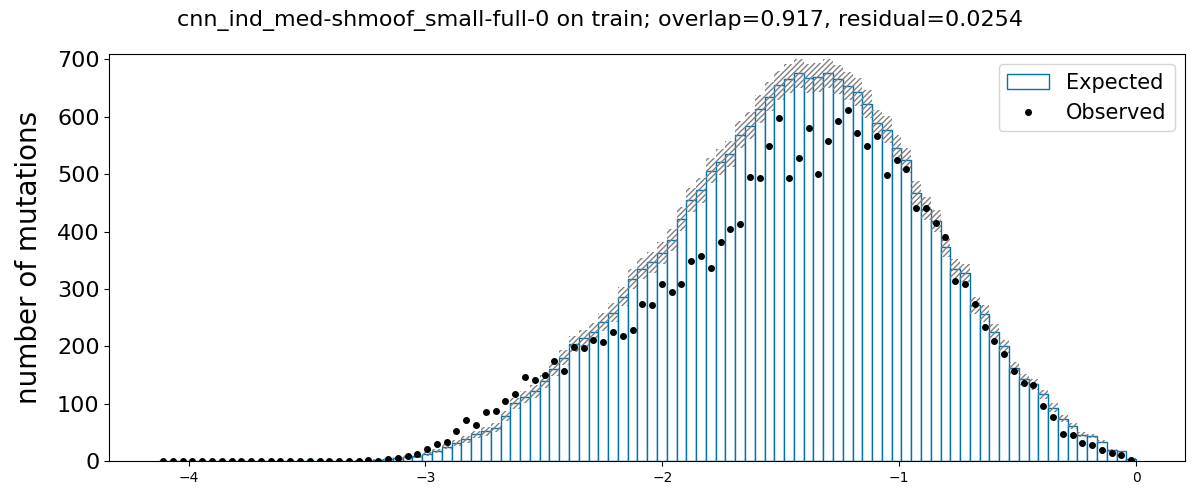

In [7]:
crepe_path = "../train/trained_models/cnn_ind_med-shmoof_small-full-0"
model_name = crepe_path.split("/")[-1]
ermine_cnn_crepe = framework.load_crepe("../train/trained_models/cnn_ind_med-shmoof_small-full-0")
show_figure(oe_plot_of_crepe(ermine_cnn_crepe, subsampled_train_df, subsampled_train_df["branch_length"], f"{model_name} on train")[0])

Finding optimal branch lengths: 100%|██████████| 5155/5155 [00:17<00:00, 298.31it/s]


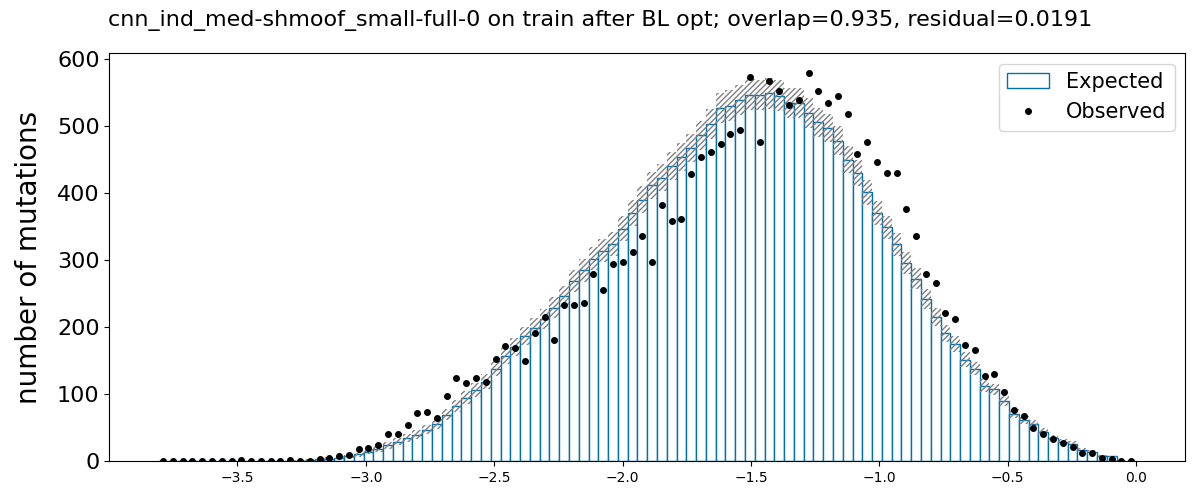

In [8]:
optimized_bls = optimized_branch_lengths_of_crepe(ermine_cnn_crepe, subsampled_train_df)
show_figure(oe_plot_of_crepe(ermine_cnn_crepe, subsampled_train_df, optimized_bls, f"{model_name} on train after BL opt")[0])